# Information Verifier System

This notebook implements an information verification system using:
- **LangGraph**: Workflow orchestration
- **LangChain**: LLM integration and tools
- **Hugging Face**: Classification models

## Requisites

- Python 3.11
- Pip package manager

## Packages Install

### With pip

In [45]:
!pip install -r requirements.txt


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


### With UV

In [46]:
!pip install uv


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip


In [47]:
!uv pip install -r requirements.txt

error: No virtual environment found; run `uv venv` to create an environment, or pass `--system` to install into a non-virtual environment


## Imports And Keys

In [48]:
import getpass
import os
# OpenAI Version
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

In [49]:
import io
import re
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from typing import TypedDict, Literal, List
from pydantic import BaseModel
from langchain_core.documents import Document
from enum import Enum, auto
from PIL import Image
from langgraph.graph import StateGraph, START, END
from nba.nba_qa_system import NBAQASystem


## Definitions

In [50]:
class ClassificationResult(Enum):
    REAL = auto()
    FAKE = auto()
    DOUBTFUL = auto()

class Source(BaseModel):
    url: str
    title: str
    snippet: str
    credibility_score: float = 0.5

class Evidence(BaseModel):
    claim: str
    supporting_text: str
    source: Source
    relevance_score: float

class VerificationState(TypedDict):
    user_input: str
    enhanced_query: str
    search_results: List[Document]
    evidence: List[Evidence]
    classification: ClassificationResult
    confidence: float
    explanation: str
    sources: List[Source]
    valid_query: str

## Models

In [51]:
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Initialize QA system with fine-tuned model
qa_system = NBAQASystem(model_name="utils/model_nba_qa_finetuned")

Device set to use mps:0


## Nodes

In [66]:
def validate_query_node(state: VerificationState) -> VerificationState:
    """Validate user query using NBA QA system's entity analyzer (hybrid approach)"""
    query = state['user_input']
    
    # Step 1: Use QA system's analyzer to extract NBA entities (fast, domain-specific)
    analysis = qa_system.analyzer.analyze(query)
    
    # Check if NBA-related entities were found
    has_players = len(analysis.entities.get('players', [])) > 0
    has_teams = len(analysis.entities.get('teams', [])) > 0
    has_stats = len(analysis.entities.get('stats', [])) > 0
    has_nba_keywords = any(keyword in query.lower() for keyword in [
        'nba', 'finals', 'playoffs', 'championship', 'basketball'
    ])
    
    # If any NBA entity found, it's NBA-related
    if has_players or has_teams or has_stats or has_nba_keywords:
        answer = "YES"
    else:
        # Step 2: Fallback to LLM for ambiguous cases
        # This handles cases like "basketball player" without specific names
        prompt = f"""Is this query about NBA (National Basketball Association) basketball? 
        Answer only YES or NO, nothing else.
        
        Query: {query}"""
        
        try:
            response = model.invoke([HumanMessage(content=prompt)])
            raw_answer = response.content.strip().upper()
            
            # Extract YES or NO from response (handles cases with extra text)
            if "YES" in raw_answer or raw_answer.startswith("Y"):
                answer = "YES"
            elif "NO" in raw_answer or raw_answer.startswith("N"):
                answer = "NO"
            else:
                # Default to NO if unclear
                answer = "NO"
        except Exception as e:
            # If LLM fails, default to NO
            print(f"Warning: LLM validation failed: {e}")
            answer = "NO"
    
    return {
        **state,
        "valid_query": answer
    }

In [67]:
def enhance_query_node(state: VerificationState) -> VerificationState:
    """Enhance user query for better search results"""
    prompt = f"""Given the following user query or claim, create an optimized search query 
    that will help verify the information. Extract key entities, dates, and facts.

    User input: {state['user_input']}
    
    Return only the enhanced search query, nothing else."""
    
    response = model.invoke([HumanMessage(content=prompt)])
    enhanced = response.content.strip()
    
    return {
        **state,
        "enhanced_query": enhanced
    }

In [68]:
def extract_evidence_node(state: VerificationState) -> VerificationState:
    """
    Extract evidence using fine-tuned NBA QA model
    """
    claim = state['user_input']
    enhanced_query = state['enhanced_query']

    try:
        # Use QA system to get evidence
        qa_result = qa_system.answer(enhanced_query or claim)

        # Create Evidence objects
        evidence_list = []
        if qa_result.answer and qa_result.confidence > 0:
            # Convert QA sources to Evidence format
            if qa_result.sources:
                for source in qa_result.sources:
                    evidence = Evidence(
                        claim=claim,
                        supporting_text=qa_result.context_used,
                        source=Source(
                            url=f"nba_api:{source.get('type', 'unknown')}",
                            title=f"NBA {source.get('type', 'data')}",
                            snippet=qa_result.answer,
                            credibility_score=qa_result.confidence
                        ),
                        relevance_score=qa_result.confidence
                    )
                    evidence_list.append(evidence)
            else:
                # If no sources but we have an answer, create a single evidence
                evidence = Evidence(
                    claim=claim,
                    supporting_text=qa_result.context_used,
                    source=Source(
                        url="nba_api:general",
                        title="NBA API Data",
                        snippet=qa_result.answer,
                        credibility_score=qa_result.confidence
                    ),
                    relevance_score=qa_result.confidence
                )
                evidence_list.append(evidence)

        return {
            **state,
            "evidence": evidence_list,
            "sources": [e.source for e in evidence_list],
            "search_results": [Document(page_content=qa_result.context_used)] if qa_result.context_used else []
        }
    except Exception as e:
        # Handle errors gracefully
        return {
            **state,
            "evidence": [],
            "sources": [],
            "search_results": [],
            "explanation": f"Error retrieving evidence from NBA API: {str(e)}"
        }

In [69]:
def classify_claim_node(state: VerificationState) -> VerificationState:
    """
    Classify claim based on QA model evidence
    """
    claim = state['user_input']
    evidence = state['evidence']

    if not evidence:
        return {
            **state,
            "classification": ClassificationResult.DOUBTFUL,
            "confidence": 0.0,
            "explanation": "⚠️ UNCERTAIN: No evidence found to verify this claim."
        }

    # Get best evidence (highest confidence)
    best_evidence = max(evidence, key=lambda e: e.relevance_score)
    qa_answer = best_evidence.source.snippet
    confidence_score = best_evidence.relevance_score
    context_used = best_evidence.supporting_text

    # Extract numbers/statistics from claim and answer for comparison
    claim_lower = claim.lower()
    answer_lower = qa_answer.lower()
    
    # Extract numbers from both claim and answer
    claim_numbers = set(re.findall(r'\d+\.?\d*', claim))
    answer_numbers = set(re.findall(r'\d+\.?\d*', qa_answer))
    
    # Extract key terms (player names, teams, etc.)
    claim_terms = set(re.findall(r'\b[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*\b', claim))
    answer_terms = set(re.findall(r'\b[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*\b', qa_answer))
    
    # Check for matches
    number_matches = bool(claim_numbers and answer_numbers and claim_numbers.intersection(answer_numbers))
    term_matches = bool(claim_terms and answer_terms and claim_terms.intersection(answer_terms))
    
    # Classification logic
    if confidence_score > 0.7:
        if number_matches or (term_matches and len(claim_terms.intersection(answer_terms)) >= 2):
            # High confidence + matching data = REAL
            classification = ClassificationResult.REAL
            explanation = f"✅ VERIFIED: The claim matches NBA API data. Found: {qa_answer} (Confidence: {confidence_score:.2f})"
        elif number_matches == False and claim_numbers:
            # High confidence but numbers don't match = FAKE
            classification = ClassificationResult.FAKE
            explanation = f"❌ DISPUTED: The claim does not match NBA API data. Claim states: {', '.join(claim_numbers)}, but found: {qa_answer} (Confidence: {confidence_score:.2f})"
        else:
            # High confidence but unclear match = REAL (trust the model)
            classification = ClassificationResult.REAL
            explanation = f"✅ VERIFIED: Evidence from NBA API: {qa_answer} (Confidence: {confidence_score:.2f})"
    elif confidence_score < 0.3:
        # Low confidence = DOUBTFUL
        classification = ClassificationResult.DOUBTFUL
        explanation = f"⚠️ UNCERTAIN: Low confidence evidence. Found: {qa_answer} (Confidence: {confidence_score:.2f})"
    else:
        # Medium confidence - check for matches
        if number_matches or term_matches:
            classification = ClassificationResult.REAL
            explanation = f"✅ VERIFIED: Evidence from NBA API: {qa_answer} (Confidence: {confidence_score:.2f})"
        else:
            classification = ClassificationResult.DOUBTFUL
            explanation = f"⚠️ UNCERTAIN: Evidence found but unclear match. Found: {qa_answer} (Confidence: {confidence_score:.2f})"

    return {
        **state,
        "classification": classification,
        "confidence": confidence_score,
        "explanation": explanation
    }

In [70]:
def decline_node(state: VerificationState) -> VerificationState:
    """Decline queries that don't relate to NBA"""
    message = f"Your query does not relate to the NBA theme.\n\nYour input: '{state['user_input']}'\n\nPlease provide a query or claim related to NBA (National Basketball Association) for verification."
    state['explanation'] = message
    return state

## Conditional Nodes

In [71]:
def decide_over_input_node(state: VerificationState) -> Literal["enhance_query", "decline"]:
    if state["valid_query"] == "YES":
        return "enhance_query"
    else:
        return "decline"

## Workflow

In [72]:
builder = StateGraph(VerificationState)

builder.add_node("enhance_query", enhance_query_node)
builder.add_node("validate_query", validate_query_node)
builder.add_node("decline", decline_node)
builder.add_node("extract_evidence", extract_evidence_node)
builder.add_node("classify_claim", classify_claim_node)

builder.add_edge(START, "validate_query")
builder.add_conditional_edges("validate_query", decide_over_input_node)
builder.add_edge("decline", END)
builder.add_edge("enhance_query", "extract_evidence")
builder.add_edge("extract_evidence", "classify_claim")
builder.add_edge("classify_claim", END)
graph = builder.compile()

### Workflow Image

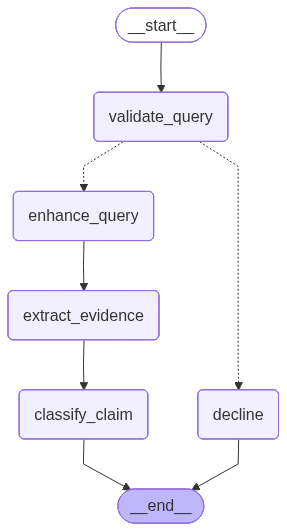

In [73]:
png_bytes = graph.get_graph(xray=True).draw_mermaid_png()
Image.open(io.BytesIO(png_bytes))

In [74]:
user_input = "Kobe Bryant scored 23 points in the 2010 NBA Finals Game 7"
#user_input = "LeBron James was a golf player?" # Should be declined
#user_input = "The capital of France is Paris." # Should be declined

In [75]:
# Example usage
config = {"configurable": {"thread_id": "1"}}

initial_state = VerificationState(
    user_input=user_input,
    enhanced_query="",
    search_results=[],
    evidence=[],
    classification=ClassificationResult.DOUBTFUL,
    confidence=0.0,
    explanation="",
    sources=[],
    valid_query=""
)

result = graph.invoke(initial_state, config)

In [76]:
# Display the results
print("=" * 80)
print("VERIFICATION RESULT")
print("=" * 80)
print(f"\n📝 Claim: {result['user_input']}")
print(f"\n✅ Valid Query: {result['valid_query']}")

if result['valid_query'] == "YES":
    print(f"\n🔍 Enhanced Query: {result['enhanced_query']}")
    
    # Classification
    classification_emoji = {
        ClassificationResult.REAL: "✅",
        ClassificationResult.FAKE: "❌",
        ClassificationResult.DOUBTFUL: "⚠️"
    }
    classification_name = {
        ClassificationResult.REAL: "VERIFIED (REAL)",
        ClassificationResult.FAKE: "DISPUTED (FAKE)",
        ClassificationResult.DOUBTFUL: "UNCERTAIN (DOUBTFUL)"
    }
    
    print(f"\n{classification_emoji.get(result['classification'], '❓')} Classification: {classification_name.get(result['classification'], 'UNKNOWN')}")
    print(f"\n📊 Confidence: {result['confidence']:.2%} ({result['confidence']:.2f})")
    
    # Evidence
    print(f"\n📚 Evidence: {len(result['evidence'])} piece(s)")
    for i, ev in enumerate(result['evidence'], 1):
        print(f"  {i}. Answer: {ev.source.snippet}")
        print(f"     Relevance Score: {ev.relevance_score:.2f}")
        print(f"     Source: {ev.source.title}")
    
    # Sources
    if result['sources']:
        print(f"\n🔗 Sources: {len(result['sources'])} source(s)")
        for i, source in enumerate(result['sources'], 1):
            print(f"  {i}. {source.title} (Credibility: {source.credibility_score:.2f})")
    
    # Explanation
    print(f"\n💡 Explanation:\n{result['explanation']}")
else:
    print(f"\n{result['explanation']}")

print("\n" + "=" * 80)

VERIFICATION RESULT

📝 Claim: Kobe Bryant scored 23 points in the 2010 NBA Finals Game 7

✅ Valid Query: YES

🔍 Enhanced Query: "Kobe Bryant 23 points 2010 NBA Finals Game 7"

⚠️ Classification: UNCERTAIN (DOUBTFUL)

📊 Confidence: 0.00% (0.00)

📚 Evidence: 11 piece(s)
  1. Answer: Kobe Bryant
     Relevance Score: 0.00
     Source: NBA player_career_stats
  2. Answer: Kobe Bryant
     Relevance Score: 0.00
     Source: NBA player_game_log
  3. Answer: Kobe Bryant
     Relevance Score: 0.00
     Source: NBA player_career_stats
  4. Answer: Kobe Bryant
     Relevance Score: 0.00
     Source: NBA player_career_stats
  5. Answer: Kobe Bryant
     Relevance Score: 0.00
     Source: NBA player_career_stats
  6. Answer: Kobe Bryant
     Relevance Score: 0.00
     Source: NBA player_career_stats
  7. Answer: Kobe Bryant
     Relevance Score: 0.00
     Source: NBA player_career_stats
  8. Answer: Kobe Bryant
     Relevance Score: 0.00
     Source: NBA player_career_stats
  9. Answer: Kobe Bryan